In [1]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
def get_binance_ohlc(symbol, interval, limit=1000):
    url = f'https://api.binance.com/api/v1/klines'
    params = {
        'symbol': symbol,
        'interval': interval,
        
        'limit': limit
    }
    response = requests.get(url, params=params)
    data = response.json()
    
    ohlc = []
    for item in data:
        ohlc.append({
            'timestamp': datetime.fromtimestamp(item[0] / 1000),
            'open': float(item[1]),
            'high': float(item[2]),
            'low': float(item[3]),
            'close': float(item[4]),
            'volume': float(item[5])

        })
    df = pd.DataFrame(ohlc)
    df.set_index('timestamp', inplace=True)
    return df



In [2]:
from datetime import datetime, timedelta

def generate_date_list(start_date_str, end_date_str, interval_days=4):
    # Convert string inputs to dat|etime objects
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
    
    # Generate list of dates
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=interval_days)
    
    return date_list

In [3]:
def get_binance_ohlc_time(symbol, interval, start_str, end_str):
    print(start_str,"->",end_str)
    url = f'https://api.binance.com/api/v1/klines'
    
    # Convert start and end times to milliseconds since epoch
    start_ts = int(datetime.strptime(start_str, '%Y-%m-%d %H:%M:%S').timestamp() * 1000)
    end_ts = int(datetime.strptime(end_str, '%Y-%m-%d %H:%M:%S').timestamp() * 1000)
    
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_ts,
        'endTime': end_ts
    }
    response = requests.get(url, params=params)
    data = response.json()
    ohlc = []
    for item in data:
        ohlc.append({
            'timestamp': datetime.fromtimestamp(item[0] / 1000),
            'open': float(item[1]),
            'high': float(item[2]),
            'low': float(item[3]),
            'close': float(item[4]),
            'volumn': float(item[5])
        })
    
    df = pd.DataFrame(ohlc)
    df.reset_index(drop=True, inplace=True)

    # df.set_index('timestamp', inplace=True)
    return df

In [4]:

def is_pin_bar(candle):
    open_price = candle['open']
    close_price = candle['close']
    high_price = candle['high']
    low_price = candle['low']
    
    body_size = abs(close_price - open_price)
    upper_wick_size = high_price - max(open_price, close_price)
    candle_range = high_price - low_price
    
    # Define Pin Bar conditions
    long_tail = (upper_wick_size > 8 * body_size)
    small_body = body_size <= 0.2 * candle_range
    
    return long_tail and small_body

def rule(df_btc, df, tp=1, sl=5, money=1000, model = None, num_random=10000, window_test=10, seq=30, time_pred=10, manual_cond=False):
    dfcopy = df.copy()
    number_high = 0
    number_low = 0
    cannot_break = 0
    results = []
    list_reward = []
    balance = 0
    price_line = []
    dfcopy['fluct'] = (dfcopy['close'] - dfcopy['open']) / dfcopy['open'] * 100

    index_condition = []
    if model is None:
        index_condition = np.random.randint(100, len(df), num_random)
    else:
        for i in range(seq+1, len(df)-1, window_test):
            x_array = df.iloc[i-seq:i]
            x_array = x_array.values[:,1:].astype(np.float32)
            min_vol = np.min(x_array[:,-1])
            max_vol = np.max(x_array[:,-1])

            # x_array[:,-1] = (x_array[:,-1]-min_vol)/(max_vol-min_vol)
            x_array[:,-1] = x_array[:,-1]/min_vol
            min_price = np.min(x_array[:,:4])
            max_price = np.max(x_array[:,:4])
            x_array[:,:4] = (x_array[:,:4] - min_price) / (max_price - min_price)


            x_array = np.array([x_array]).reshape(1, -1)
            dtest = xgb.DMatrix(x_array)
            y_pred_prob = int(model.predict(dtest)[0])
            # y_pred_prob2 = int(bst2.predict(dtest)[0])
            if y_pred_prob == 1:
                if manual_cond:
                    if dfcopy.iloc[i-1]['fluct'] <  0 or dfcopy.iloc[i-2]['fluct'] <  0 or is_pin_bar(df.iloc[i-1]):   # it nhat 1 nen do trong 2 nen truoc do
                        index_condition.append(i)
                else:
                    index_condition.append(i)
    index_condition = sorted(index_condition)
    for i in index_condition:
        a = df['open'].iloc[i]
        high_check = False
        low_check = False
        if time_pred == "all":
            end = len(df)
        else:
            end = i+time_pred
        for j in range(i,end):
            if j >= len(df):
                break
            high_check = df['high'].iloc[j] >= (1+sl*0.01) * a
            low_check = df['low'].iloc[j] <= (1-tp*0.01) * a
            if high_check and low_check:
                print("check lai")
                break
            if high_check:
                balance += -money*sl/100
                list_reward.append(balance)
                price_line.append(j)
                number_high+=1
                results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "high"))
                break
            if low_check:
                price_line.append(j)
                balance += money*tp/100
                list_reward.append(balance)
                number_low+=1
                # print(df.iloc[i])
                # print("low", j-i)
                results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "low"))
                break
        if not high_check and not low_check and j<len(df):
            if df.iloc[j]['close'] < a:
                # print("win: ", df.iloc[j]['close'], df.iloc[i]['open'], money * (1 - df.iloc[j]['close'] / df.iloc[i]['open']))
                pnl = money * (1 - df.iloc[j]['close'] / df.iloc[i]['open'])
                balance += pnl
            else:
                # print("lose: ", df.iloc[j]['close'], df.iloc[i]['open'], -money * (df.iloc[j]['close'] / df.iloc[i]['open']-1))
                pnl = -money * (df.iloc[j]['close'] / df.iloc[i]['open']-1)
                balance += pnl
            list_reward.append(balance)
            price_line.append(j)
            results.append((i, df.iloc[i]['timestamp'], df.iloc[j]['timestamp'], "not", round(pnl, 2)))
            cannot_break += 1
    prices_list = df.loc[price_line, 'open'].tolist()

    print("num points: ", len(index_condition), "number_low/all_point", round(number_low/(number_low+number_high+0.01), 3), "cannot_break", cannot_break)

    return results, index_condition, number_high, number_low, list_reward, prices_list

In [5]:
start = "2024-09-19"
end = "2024-09-24"
list_day = generate_date_list(start, end, 4)
list_day.append(end)
df_all = []
symb = "ORDIUSDT"
interval = "15m"
for i in range(len(list_day)-1):
    df = get_binance_ohlc_time(symb, interval, list_day[i]+" 00:15:00", list_day[i+1]+" 00:00:00")
    df_all.append(df)
df_all = pd.concat(df_all,ignore_index=True, axis=0)
csv_file = f"data_his/{symb}_{start}_{end}_{interval}.csv"
df_all.to_csv(csv_file, index=False)
df_all = pd.read_csv(csv_file)
# df_all = pd.read_csv("data_his/ORDIUSDT_2024-08-11_2024-09-03_15m.csv")

2024-09-19 00:15:00 -> 2024-09-23 00:00:00
2024-09-23 00:15:00 -> 2024-09-24 00:00:00


In [6]:
df_all

,timestamp,open,high,low,close,volumn
0,2024-09-19 00:15:00,28.88,29.17,28.86,29.16,8483.30
1,2024-09-19 00:30:00,29.15,29.38,29.12,29.36,7193.54
2,2024-09-19 00:45:00,29.36,29.57,29.27,29.37,24225.27
3,2024-09-19 01:00:00,29.36,31.01,29.28,29.74,220402.13
4,2024-09-19 01:15:00,29.75,30.34,29.72,30.24,48051.29
...,...,...,...,...,...,...
378,2024-09-22 22:45:00,33.50,33.53,33.41,33.45,2425.42
379,2024-09-22 23:00:00,33.45,33.49,33.15,33.18,20355.38
380,2024-09-22 23:15:00,33.18,33.34,33.07,33.29,19356.83
381,2024-09-22 23:30:00,33.30,33.55,33.22,33.46,5243.24


In [60]:
df = df_all.iloc[:14000].reset_index(drop=True)#.drop(columns=['fluct', 'amp'])
display(df.head(1))
display(df.tail(2))
rs, idcond, high_check, low_check, list_reward, prices_list = rule(df, df, tp=3, sl=3, num_random=10000)


,timestamp,open,high,low,close,volumn
0,2022-05-11 01:00:00,113.2,113.2,110.0,110.5,14359.716


,timestamp,open,high,low,close,volumn
13998,2023-12-15 08:00:00,104.19,105.72,104.04,105.48,12804.295
13999,2023-12-15 09:00:00,105.48,105.69,104.44,104.68,10002.213


check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
check lai
num points:  10000 number_low/all_point 0.49 cannot_break 5302


In [65]:
np.where(np.isnan(x))

(array([5363, 5364, 5365, 5366, 5367, 5368, 5369, 5370, 5371, 5372, 5373,
        5374, 5375, 5376, 5377, 5378, 5379, 5380, 5381, 5382, 5383, 5384,
        5385, 5386, 5387, 5388, 5389, 5390]),
 array([144, 139, 134, 134, 134, 134, 129, 109, 109, 104, 104, 104,  99,
         94,  69,  59,  59,  59,  54,  54,  44,  34,  29,  19,  19,  14,
         14,  14]))

Accuracy: 72.94%


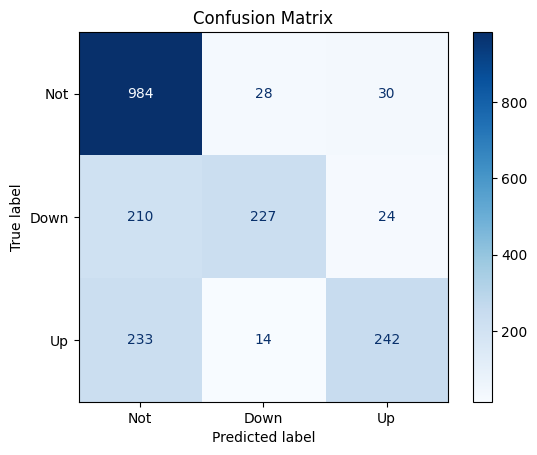

In [74]:
def create_dataset(df, rs, sequence_length):
    x = []
    y = []
    for point in rs:
        index = point[0]
        
        x_array = df_all.iloc[index-sequence_length:index].values[:,1:].astype(np.float32)
        
        min_vol = np.min(x_array[:,-1])
        max_vol = np.max(x_array[:,-1])
        if min_vol == 0:
            continue

        # x_array[:,-1] = (x_array[:,-1]-min_vol)/(max_vol-min_vol)
        x_array[:,-1] = x_array[:,-1]/min_vol

        min_price = np.min(x_array[:,:4])
        max_price = np.max(x_array[:,:4])
        x_array[:,:4] = (x_array[:,:4] - min_price) / (max_price - min_price)
        x.append(x_array)

        if point[-1] == "low":
            y.append(1)
        elif point[-1] == "high":
            y.append(2)
        else:
            y.append(0)
    return x, y

x, y = create_dataset(df_all, rs, 30)
x = np.array(x)
y = np.array(y)
x = x.reshape(x.shape[0], -1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)


param = {
    'max_depth': 25,
    'eta': 0.1,
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': 3,                # Number of classes
    'eval_metric': 'merror'       # Multiclass classification error rate
}

# Train the model
num_round = 50
bst = xgb.train(param, dtrain, num_round)

# Make predictions
y_pred_prob = bst.predict(dtest)
y_pred = y_pred_prob.astype(int) # Convert predicted probabilities to class labels

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Not', 'Down', "Up"])
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [7]:
bst2 = xgb.Booster()


In [8]:
bst2.load_model('xgboost_model_ORDI_15m_15k_first_maxdepth20_3class.json')

In [41]:
# bst.save_model(f"{symb}_{interval}_tp4_sl4_75pceent_no_mancond.json")

In [11]:
df_all

,timestamp,open,high,low,close,volumn
0,2024-09-19 00:15:00,28.88,29.17,28.86,29.16,8483.30
1,2024-09-19 00:30:00,29.15,29.38,29.12,29.36,7193.54
2,2024-09-19 00:45:00,29.36,29.57,29.27,29.37,24225.27
3,2024-09-19 01:00:00,29.36,31.01,29.28,29.74,220402.13
4,2024-09-19 01:15:00,29.75,30.34,29.72,30.24,48051.29
...,...,...,...,...,...,...
285,2024-09-21 23:30:00,36.12,36.21,36.02,36.11,4948.56
286,2024-09-21 23:45:00,36.11,36.18,36.01,36.02,4757.67
287,2024-09-22 00:00:00,36.04,36.09,35.87,35.99,6041.89
288,2024-09-22 00:15:00,36.01,36.07,35.49,35.68,19791.29


In [15]:
# df = df_all.reset_index(drop=True)#.drop(columns=['fluct', 'amp'])
# df = pd.read_csv("data_his/ORDIUSDT_2023-06-12_2024-08-11_15m.csv")
# df = get_binance_ohlc_time(symb, interval,"2024-07-09 00:15:00", "2024-09-10 00:00:00")
# df = df_all.iloc[14000:].reset_index(drop=True)
df = df_all
display(df.head(1))
display(df.tail(2))
rs2, idcond, high_check, low_check, list_reward, prices_list = rule(df, df, tp=1, sl=5, model=bst2, num_random=1000, window_test=1, seq=30, time_pred= 10,manual_cond=True)
list_reward[-1]


,timestamp,open,high,low,close,volumn
0,2024-09-19 00:15:00,28.88,29.17,28.86,29.16,8483.3


,timestamp,open,high,low,close,volumn
381,2024-09-22 23:30:00,33.30,33.55,33.22,33.46,5243.24
382,2024-09-22 23:45:00,33.46,33.62,33.46,33.55,7687.90


num points:  14 number_low/all_point 0.998 cannot_break 8


58.346132358007736

In [10]:
idcond

[97, 100, 110, 111, 112, 114, 115, 283, 284, 285, 288, 289, 290, 292]

In [14]:
rs2

[(97, '2024-09-20 00:30:00', '2024-09-20 01:30:00', 'high'),
 (100, '2024-09-20 01:15:00', '2024-09-20 03:30:00', 'not', 9.86),
 (110, '2024-09-20 03:45:00', '2024-09-20 06:00:00', 'not', -5.27),
 (111, '2024-09-20 04:00:00', '2024-09-20 06:15:00', 'not', -3.22),
 (112, '2024-09-20 04:15:00', '2024-09-20 06:30:00', 'not', -3.81),
 (114, '2024-09-20 04:45:00', '2024-09-20 07:00:00', 'not', -3.51),
 (115, '2024-09-20 05:00:00', '2024-09-20 07:15:00', 'not', 4.71),
 (283, '2024-09-21 23:00:00', '2024-09-22 01:15:00', 'not', 10.28),
 (284, '2024-09-21 23:15:00', '2024-09-22 01:30:00', 'not', 14.39),
 (285, '2024-09-21 23:30:00', '2024-09-22 01:45:00', 'not', 16.61),
 (288, '2024-09-22 00:15:00', '2024-09-22 02:30:00', 'not', 15.27),
 (289, '2024-09-22 00:30:00', '2024-09-22 02:45:00', 'not', 8.13),
 (290, '2024-09-22 00:45:00', '2024-09-22 03:00:00', 'not', 4.77),
 (292, '2024-09-22 01:15:00', '2024-09-22 03:30:00', 'not', 6.45)]

In [90]:
def find_peaks_and_bottoms(df):
    # Ensure the DataFrame has 'high' and 'low' columns
    assert 'high' in df.columns and 'low' in df.columns, "DataFrame must contain 'high' and 'low' columns"
    df['mean_open_10'] = df['open'].rolling(window=10, min_periods=1).mean()

    # Identify peaks and bottoms
    peaks = []
    bottoms = []

    for i in range(10, len(df) - 1):
        if df['open'].iloc[i] > df['mean_open_10'].iloc[i - 1] and df['open'].iloc[i] > df['mean_open_10'].iloc[i + 1]:
            peaks.append(i)
        if df['open'].iloc[i] < df['mean_open_10'].iloc[i - 1] and df['open'].iloc[i] < df['mean_open_10'].iloc[i + 1]:
            bottoms.append(i)

    return peaks, bottoms

In [80]:
df = df_all[-500:]

In [ ]:
df = pd.read_csv("./data_his/ORDIUSDT_2024-08-11_2024-09-03_15m.csv")
df.rename(columns={'volumn': 'volume'}, inplace=True)

df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)


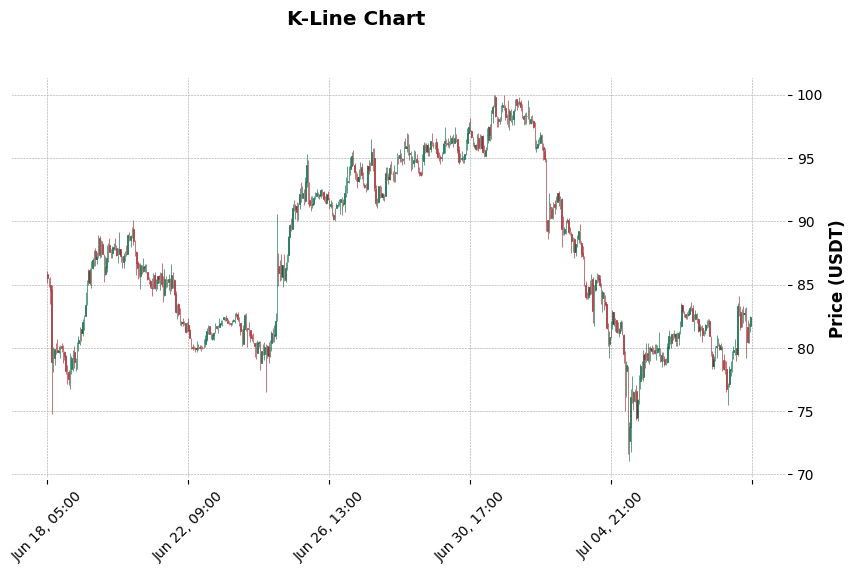

In [88]:
import mplfinance as mpf


mpf.plot(df, type='candle', style='charles', volume=False, title=f"K-Line Chart", ylabel='Price (USDT)', figratio=(15, 8),  figscale=1)

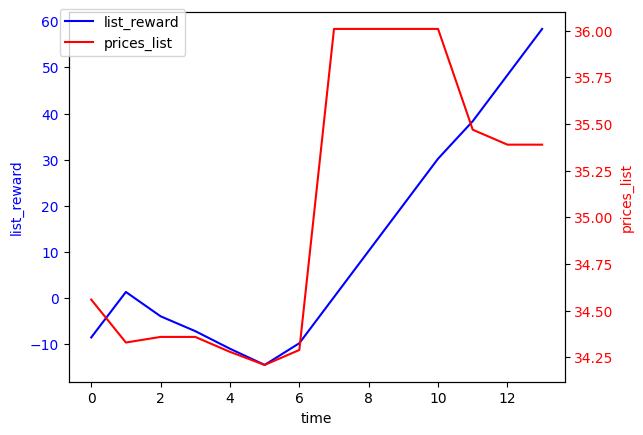

In [16]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()

ax1.plot(list_reward, 'b-', label='list_reward')
ax1.set_xlabel('time')
ax1.set_ylabel('list_reward', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(prices_list, 'r-', label='prices_list')
ax2.set_ylabel('prices_list', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# plt.title('Two Lists with Different Scales')
plt.show()


In [ ]:
def create_dataset(df, rs, sequence_length):
    x = []
    y = []
    for point in rs:
        index = point[0]
        y.append(point[-1] == "low")
        x_array = df_all.iloc[index-sequence_length:index].values[:,1:].astype(np.float32)
        x_array[:,-1] = x_array[:,-1]/20000
        x.append(x_array)
    return x, y

        
    

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

# Hyperparameters
input_size = 5  # Single feature (price)
hidden_size = 50  # Number of features in hidden state
num_layers = 2  # Number of stacked LSTM layers
output_size = 1  # Predict the next price
num_epochs = 100
learning_rate = 0.001
sequence_length = 60  # Number of past prices to use for prediction
train_ratio = 0.9
d_model = 64  # Embedding dimension
nhead = 4  # Number of attention heads
num_encoder_layers = 2  # Number of transformer encoder layers
fc1_size = 32  # Number of neurons in the first fully connected layer
fc2_size = 16
x, y = create_dataset(df_all, rs, sequence_length)

# Convert to PyTorch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

print(x.shape)
# Split data into training and validation sets
dataset = TensorDataset(x, y)
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, output_size, sequence_length):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, sequence_length, d_model))  # Positional encoding
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead), num_encoder_layers)
        self.fc = nn.Linear(d_model, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Add positional encoding
        x = self.embedding(x) + self.pos_encoder
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])  # Only use the last time step's output
        x = self.sigmoid(x)
        return x
    
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, fc1_size, fc2_size, output_size):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        # Define the LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the fully connected layers
        self.fc1 = nn.Linear(hidden_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, output_size)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc1(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)  # Use sigmoid for binary classification
        return out

model = LSTMModel(input_size, hidden_size, num_layers, fc1_size, fc2_size, output_size)
# model = TransformerModel(input_size, d_model, nhead, num_encoder_layers, output_size, sequence_length)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
for epoch in range(num_epochs):
    for i, (prices, labels) in enumerate(train_loader):
        outputs = model(prices)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



In [ ]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

# Validation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for prices, labels in val_loader:
        outputs = model(prices).squeeze()
        predicted = (outputs >= 0.5).float()
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# Calculate precision and recall
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
print(f'Validation Precision: {precision:.4f}')
print(f'Validation Recall: {recall:.4f}')

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Up', 'Down'])
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
torch.save(model, "LSTM_seq_30.pt")

In [ ]:
model.eval()
index = 25500
with torch.no_grad():
    array_seq = df_all.iloc[index-sequence_length:index].values
    print("time: ", array_seq[-1, 0], )
    display(df_all.iloc[index])
    tens_seq = torch.tensor(array_seq[:,1:].astype(np.float32), dtype=torch.float32).unsqueeze(0)
    next_movement = model(tens_seq)
    prediction = "Down" if next_movement.item() >= 0.5 else "Up"
    print(f'Predicted next movement: {prediction}')

In [ ]:
array_seq[:,1:]

In [ ]:
import time
from datetime import datetime
from binance.spot import Spot
from binance_ft.um_futures import UMFutures
from helper import get_commision, get_precision, get_status_pos, key, secret, xlsx_to_nested_dict
from datetime import datetime, timedelta

# Initialize the Binance client
api_key="7NvUEUX4tnzOja5KQ99gmUG37DQOV9oelvz1akWAr2Zts9X57djRMwbvfgjQoykp"
api_secret="X9CWCXNsdypjEU8Q0AQaoaqPrcnaX4wpDe5KVxsAfThkVJJAvufiGJ3tb95QqnQC"
# client = UMFutures(key="c21f1bb909318f36de0f915077deadac8322ad7df00c93606970441674c1b39b", secret="be2d7e74239b2e959b3446b880451cbb4dee2e6be9d391c4c55ae7ca0976f403", base_url="https://testnet.binancefuture.com")
client = UMFutures(key=api_key, secret=api_secret)



In [ ]:
res = client.get_all_orders("ORDIUSDT")

In [ ]:
res = client.get_account_trades("ORDIUSDT")

In [ ]:
res[-]